In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
""" ARIMA can take into account non-stationary
time series and avoid the steps of modeling on differenced data and having to
inverse transform the forecasts. """
""" This procedure involves fitting many ARMA(p,q) models and
selecting the one with the lowest AIC. Then we study the model’s residuals to verify
that they resemble white noise. """

' This procedure involves fitting many ARMA(p,q) models and\nselecting the one with the lowest AIC. Then we study the model’s residuals to verify\nthat they resemble white noise. '

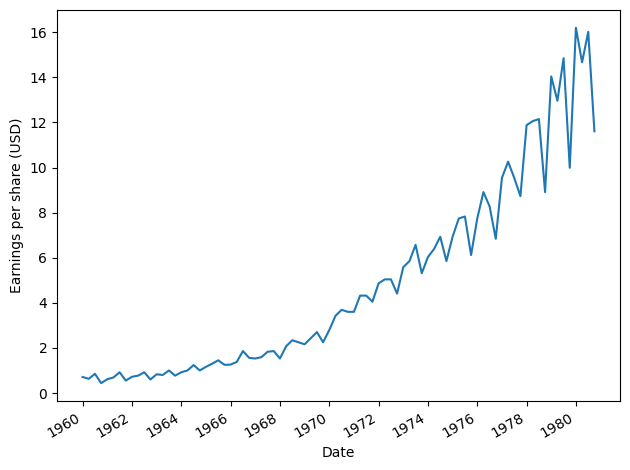

In [3]:
df = pd.read_csv('data/jj.csv')
fig, ax = plt.subplots()
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,
                                 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

In [4]:
""" apply the augmented Dickey-Fuller (ADF) test to determine if it is stationary or not. """
ad_fuller_result = adfuller(df['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

""" This block of code returns an ADF statistic of 2.74 with a p-value of 1.0. Since the ADF
statistic is not a large negative number, and the p-value is larger than 0.05 """

ADF Statistic: 2.7420165734574744
p-value: 1.0


' This block of code returns an ADF statistic of 2.74 with a p-value of 1.0. Since the ADF\nstatistic is not a large negative number, and the p-value is larger than 0.05 '

In [5]:
""" We need to determine how many times the series must be differenced to become
stationary. This will then set the order of integration d. We can apply a first-order dif-
ferencing and test for stationarity. """
eps_diff = np.diff(df['data'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


In [6]:
""" Let’s try differencing again to see if the series becomes stationary """
eps_diff2 = np.diff(eps_diff, n=1)
ad_fuller_result = adfuller(eps_diff2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


In [7]:
#Function to fit all unique ARIMA(p,d,q) models
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
#define a list of possible values for the orders p and q (0,1,2,3)
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [9]:
""" The returned DataFrame shows that a value of 3 for both p and q results in the lowest
AIC. Therefore, an ARIMA(3,2,3) model seems to be the most suitable for this situa-
tion. """
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.266637
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430625
4,"(0, 3)",194.654716
5,"(0, 2)",209.274868
6,"(2, 3)",220.666965
7,"(1, 3)",228.267730
8,"(1, 2)",228.935782
9,"(2, 2)",229.974691


In [10]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

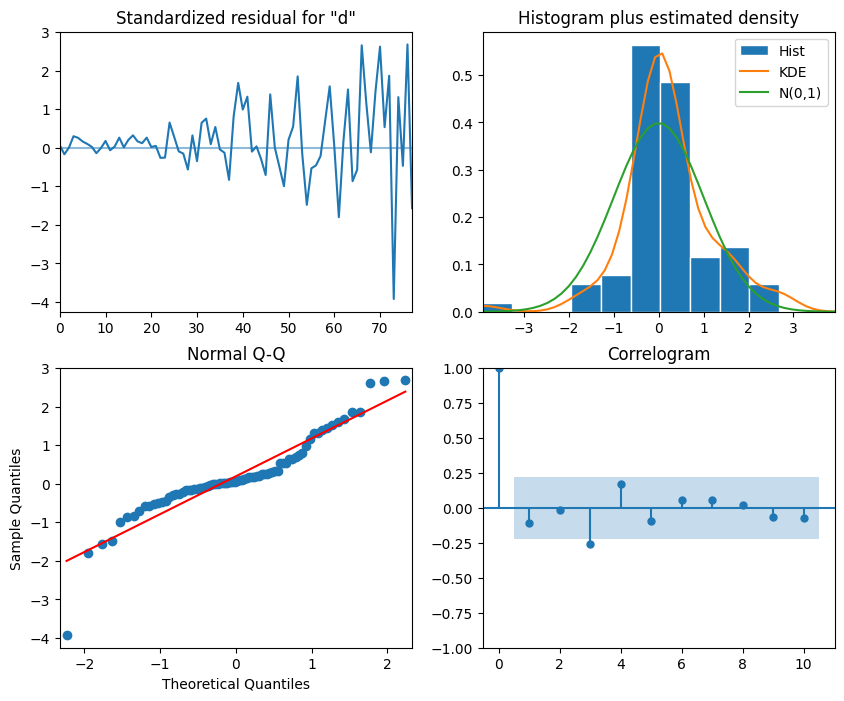

In [11]:
""" Evaluate the model by using plots """
model_fit.plot_diagnostics(figsize=(10,8));

In [28]:
""" Evaluate the model using the Ljung-Box test We’ll
apply the test on the first 10 lags and study the p-values. If all p-values are greater than 
0.05, we cannot reject the null hypothesis and we’ll conclude that the residuals are not
correlated, just like white noise."""
residuals = model_fit.resid
ljungbox = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(ljungbox.lb_pvalue)

1     0.198684
2     0.437241
3     0.063597
4     0.055573
5     0.079497
6     0.120621
7     0.169751
8     0.239426
9     0.295303
10    0.345196
Name: lb_pvalue, dtype: float64


In [32]:
""" The naive seasonal forecast is implemented by selecting the quarterly EPS
reported in 1979 and using the same values as a forecast for the year 1980. """
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [33]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858693
81,1980-04-01,14.67,12.96,14.381508
82,1980-07-02,16.02,14.85,16.365509
83,1980-10-01,11.61,9.99,11.680906


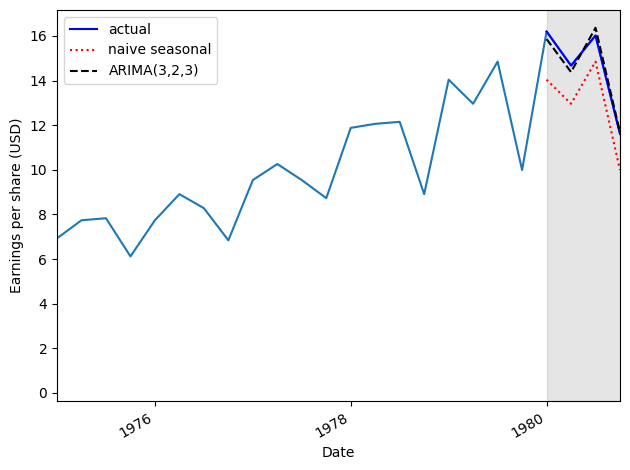

In [35]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F08_peixeiro.png', dpi=300)

In [36]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7102112169997594


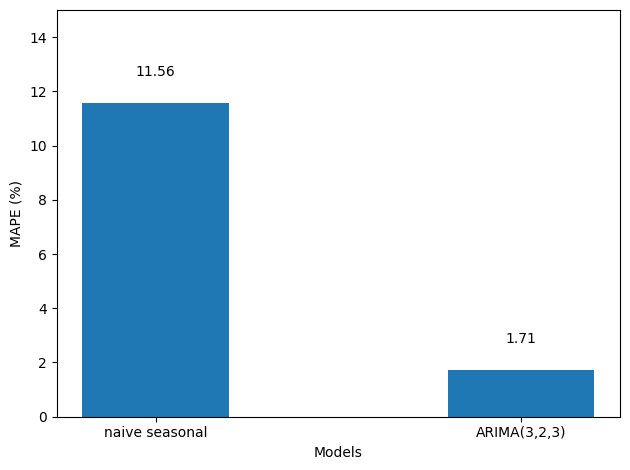

In [38]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH07_F09_peixeiro.png', dpi=300)